# Nonlinear Virus Spread

In this demo we consider a model for the spead of a virus (not COVID-19!) in a population. We are interested in estimating the reproduction rate from daily observations of the number of infected individuals. The reproduction rate indicates how many others are (on average) infected by one infected individual per time unit.

In [5]:
using Rocket
using GraphPPL
using ReactiveMP
using Plots 
using Distributions

## Generate Data

We start by generating a toy dataset for a virus with a reproduction rate $a$. Here, $y$ represents the measured number of infected individuals, and $x$ a latent state.

In [6]:
# Generate toy dataset
T = 15
x_0_data = 0.6
a_data = 1.2

x_data = Vector{Float64}(undef, T)
y_data = Vector{Float64}(undef, T)

x_t_min_data = x_0_data
for t=1:T
    x_data[t] = a_data*x_t_min_data
    y_data[t] = ceil(x_data[t])
    
    x_t_min_data = x_data[t]
end    
;

In [7]:
print(T)

15

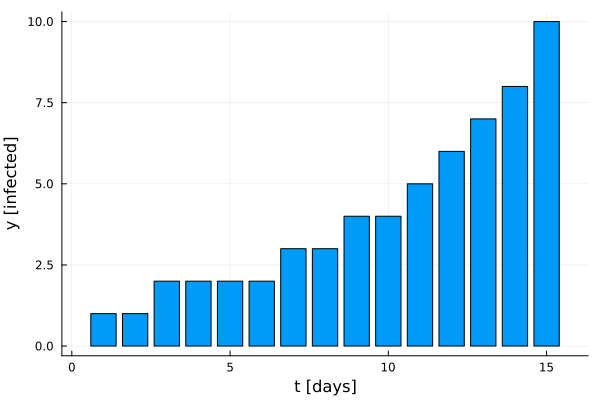

In [8]:
# Inspect data
bar(1:T, y_data, xlabel="t [days]", ylabel="y [infected]", label=false)

## Define Model

We define a state-space model, where we specify the state transition by a `Delta` node. 

In [9]:
g(x_t_min, a) = a*x_t_min
@model function virus_spread(n)
    x = randomvar(n)
    y = datavar(Float64, n)

    a ~ NormalMeanVariance(0.6, 1.0)
    x_0 ~ NormalMeanVariance(1.0, 1.0)

    x_prev = x_0
    for i in 1:n
        x[i] ~ g(x_prev, a) where {meta = ET()}
        y[i] ~ NormalMeanVariance(x[i], 0.6)
        x_prev = x[i]
    end

end

In [29]:
n = length(y_data)
imessages = (a = NormalMeanVariance(1.0, 1.0), )
result = inference(model = Model(virus_spread, n), options=(limit_stack_depth=100, ),returnvars = (a = KeepLast()), initmessages=imessages, data=(y=y_data,), free_energy=true, showprogress=true)



Inference results:
-----------------------------------------
Free Energy: Real[8.45224]
-----------------------------------------
a   = NormalWeightedMeanPrecision{Float64}(xi=67.96705980517403, w=54.49187953665651)
x_0 = NormalWeightedMeanPrecision{Float64}(xi=1.7620246540525362, w=1.702932844806627)...
x   = NormalWeightedMeanPrecision{Float64}[NormalWeightedMeanPrecision{Float64}(xi=3.0...


In [30]:
m_x_t, v_x_t = mean.(result.posteriors[:x]), cov.(result.posteriors[:x])

([1.069400046427103, 1.2197668136858266, 1.7364116037542612, 1.9608868448029853, 2.0072811325864235, 2.103856279642064, 2.8928297775918175, 3.0486973040414473, 3.9434883262277873, 4.032453719157208, 4.9885424429161045, 5.992419820924944, 6.995579191786935, 8.006141622545718, 9.793814436257565], [0.34888886675634667, 0.3319133583066991, 0.37597144487125017, 0.45510890948678484, 0.4718151035333303, 0.4743897904379749, 0.4999405220383628, 0.5305976421569929, 0.5453059956958287, 0.5589180479923471, 0.5660377879506905, 0.5767522447291646, 0.583268945976607, 0.5873874340809104, 0.4034784190496388])

In [31]:
m_a, v_a = mean.(result.posteriors[:a]), cov.(result.posteriors[:a])

(1.247287859826028, 0.018351358193238743)

In [32]:
result.free_energy

1-element Vector{Real}:
 8.452235868779677

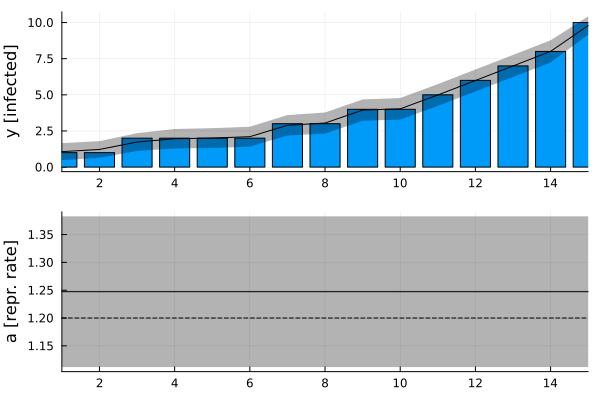

In [33]:
p1 = bar(1:T, y_data, label=false)
plot!(1:T, m_x_t, color=:black, ribbon=sqrt.(v_x_t), fillalpha=0.3, xlim=(1,T), ylabel="y [infected]", label=false)
p2 = plot(1:T, m_a*ones(T,), color=:black, ribbon=sqrt.(v_a)*ones(T,), fillalpha=0.3, xlim=(1,T), ylabel="a [repr. rate]", label=false)
plot!(1:T, a_data*ones(T), color=:black, linestyle=:dash, label=false)

l = @layout [a; b]
plot(p1, p2,  layout = l)

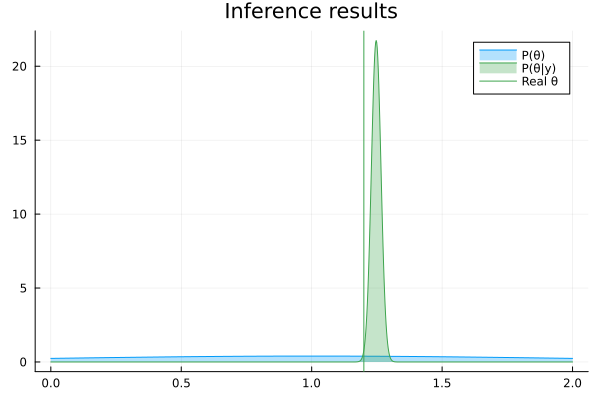

In [35]:
using Plots

rθ = range(0., 2, length = 1000)

p = plot(title = "Inference results")

plot!(rθ, (x) -> pdf(Normal(1.0, 1.0), x), fillalpha=0.3, fillrange = 0, label="P(θ)", c=1,)
plot!(rθ, (x) -> pdf(Normal(mean(result.posteriors[:a]), var(result.posteriors[:a])), x), fillalpha=0.3, fillrange = 0, label="P(θ|y)", c=3)
vline!([a_data], label="Real θ")